# [실습] Agent의 Planning ReAct 알아보기

`ToolNode`와 `ToolCondition`을 통해 툴을 실행하는 에이전트 구조를 만들어 보았습니다.

이 구조는 랭그래프에서 ReAct 에이전트라는 형태로 구현이 되어 있습니다.

In [1]:
!pip install langgraph langchain langchain_google_genai langchain_community langchain_experimental

  Using cached langchain_experimental-0.3.4-py3-none-any.whl.metadata (1.7 kB)
INFO: pip is looking at multiple versions of langchain-experimental to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langchain-experimental to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of langchain to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langchain to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to

API 키와 LLM을 설정합니다.

In [2]:
import os
os.environ['GOOGLE_API_KEY'] = 'AIxxx'

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

# rate limiter를 LLM에 적용
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    rate_limiter=rate_limiter,
    # temperature
    # max_tokens

    thinking_budget = 500  # 추론(Reasoning) 토큰 길이 제한
)

LLM에서 사용할 툴을 설정합니다.

In [3]:
# Tavily API
os.environ['TAVILY_API_KEY'] = 'tvly-xxxx'


from langchain_tavily import TavilySearch
from langchain_core.tools import tool
import random

tavily_search = TavilySearch(
    max_results=5)

@tool
def current_date() -> str:
    "현재 날짜를 %y-%m-%d 형식으로 반환합니다."
    from datetime import datetime
    return datetime.now().strftime("%Y-%m-%d")


@tool
def counsel(problem:str) -> str: # 나중에는 LLM 기반의 모듈이나, 개별 에이전트로 처리 가능
    "고민에 대한 답을 예/아니오로 얻습니다."
    if random.random()>=0.5:
        return '네!'
    else:
        return '아니오.'

print(current_date.invoke({}))
print(counsel.invoke({'problem':'아무 고민'}))




2025-10-26
네!


이번에는 새로운 툴을 추가해 보겠습니다.   
`Python_REPL`은 파이썬 쉘을 이용해서 코드를 실행하는 기능으로, ChatGPT의 코드 인터프리터와 유사합니다.

- LangChain 0.3까지는 지원되었으나, 해당 기능은 최근 랭체인에서 지원이 종료되어 직접 구현합니다.

In [9]:
from langchain_core.tools import tool
from io import StringIO
import sys
from contextlib import redirect_stdout

def python_repl(code: str) -> str:
    """
    Python 코드를 실행합니다.
    결과를 보려면 반드시 print()를 사용하세요.
    
    Args:
        code: 실행할 Python 코드
    
    Returns:
        실행 결과
    """
    # 코드 정리
    code = code.strip().strip('`')
    if code.startswith('python'):
        code = code[6:].strip()
    
    # stdout 캡처 (context manager 사용으로 안전하게)
    buffer = StringIO()
    
    try:
        # redirect_stdout을 사용하면 자동으로 복원됨
        with redirect_stdout(buffer):
            exec(code, globals())
        
        # 결과 가져오기
        output = buffer.getvalue()
        return output if output else "실행 완료 (출력 없음)"
        
    except Exception as e:
        return f"Error: {type(e).__name__}: {str(e)}"

@tool
def repl_tool(code: str) -> str:
    """
    파일 시스템 처리, 외부 API 호출 등의 다양한 작업을 위해
    Python 코드를 실행합니다.
    결과를 보려면 반드시 print()를 사용하세요.
    """
    result = python_repl(code)
    return result

# 테스트
print("=== 테스트 시작 ===")
print(python_repl("print(2 + 2)"))
print("=== 이 메시지가 보여야 합니다 ===")

=== 테스트 시작 ===
4

=== 이 메시지가 보여야 합니다 ===


React Agent는 `langgraph.prebuilt` 에서 바로 실행할 수 있습니다.

In [20]:
from langgraph.prebuilt import create_react_agent

tools = [tavily_search, current_date, counsel, repl_tool]

graph = create_react_agent(llm, tools=tools)


# LangChain V1에서는 아래 코드로 변경
# from langchain.agents import create_agent
# agent = create_agent(llm, tools=tools, system_prompt = prompt)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_27232\1098319327.py:5: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  graph = create_react_agent(llm, tools=tools)


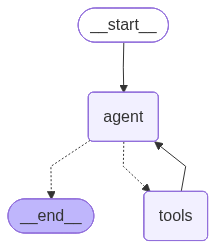

In [21]:
graph

In [22]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

graph.invoke({'messages':[HumanMessage(content="안녕하세요?")]})

{'messages': [HumanMessage(content='안녕하세요?', additional_kwargs={}, response_metadata={}, id='8dc9249f-647f-46b2-a268-fc53eb0fd9b8'),
  AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--107f2505-dd9f-4426-9673-584e8016c892-0', usage_metadata={'input_tokens': 1686, 'output_tokens': 8, 'total_tokens': 1694, 'input_token_details': {'cache_read': 0}})]}

In [24]:
for data in graph.stream(
    {'messages':[
        HumanMessage(content='''
오늘 날짜 확인해서 txt 파일로 저장해, 파일 이름은 날짜.txt로 해.''')]},
    stream_mode='updates'):
    print(data)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'current_date', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--7a3dbad5-036d-4606-8ea0-91f32a59ed0d-0', tool_calls=[{'name': 'current_date', 'args': {}, 'id': 'd2f1b048-688a-4773-8489-a4422d43ffcf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1706, 'output_tokens': 164, 'total_tokens': 1870, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 154}})]}}
{'tools': {'messages': [ToolMessage(content='2025-10-26', name='current_date', id='923ed835-719c-4a3c-ae22-e4543cc99ca5', tool_call_id='d2f1b048-688a-4773-8489-a4422d43ffcf')]}}
{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'repl_tool', 'arguments': '{"code": "

이번에는 Tool Node, ToolCondition 등의 Prebuilt 없이 구현해 보겠습니다.

In [25]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages : Annotated[list, add_messages]   # 메시지 맥락을 저장하는 리스트


In [26]:
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(rate_limiter=<langchain_core.rate_limiters.InMemoryRateLimiter object at 0x000001CCB416D5B0>, model='models/gemini-2.5-flash', google_api_key=SecretStr('**********'), thinking_budget=500, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x000001CCB62BD700>, default_metadata=(), model_kwargs={}), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'a

In [27]:
from langchain_core.messages import ToolMessage

tool_list = {tool.name: tool for tool in tools}
# tool 목록 dict로 생성

def tool_node(state):
    tool_outputs = []
    tool_call_msgs = state['messages'][-1]
    # 마지막 메시지: 툴 콜링 메시지

    for tool_call in tool_call_msgs.tool_calls:
    # 여러 개의 툴 콜이 필요한 경우를 고려해 for로 표시
        tool_exec = tool_list[tool_call['name']]
        # 실제 함수 찾기
        tool_result = tool_exec.invoke(tool_call)
        # tool 실행 결과 얻기 (결과는 ToolMessage 타입: 1번 실습 참고)
        tool_outputs.append(tool_result)

    return {'messages': tool_outputs}

def agent(state):

    # system_prompt = SystemMessage("주어진 툴을 사용하여, 사용자의 질문에 답하세요.")

    # ReAct 목적에 충실한 버전
    system_prompt = SystemMessage("""주어진 툴을 사용하여, 사용자의 질문에 답하세요.
툴을 실행하기 전, 직전까지의 결과의 의미를 파악하고 맥락에 맞게 다음 툴을 실행하기 위한 Planning Step을 메시지에 포함해 출력하세요.
파일 시스템 접근은 파이썬 코드를 실행하여 처리하세요.
에러가 발생하면, 전략을 바꿔 다시 실행하세요.""")


    response = llm_with_tools.invoke([system_prompt] + state["messages"])
    # Tool Calling이 필요한 경우와 필요하지 않은 경우를 구분할할 필요
    return {'messages': response}

def tool_needed(state):

    last_msg = state['messages'][-1]
    if last_msg.tool_calls: # 툴 콜링이 필요하면
        return "continue"
    else:
        return "finish"

In [28]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

builder.add_node("agent", agent)
builder.add_node("tools", tool_node)

builder.add_edge(START, 'agent'),
builder.add_conditional_edges("agent",
                              tool_needed,
                               {"continue": "tools","finish": END})
builder.add_edge("tools", "agent")

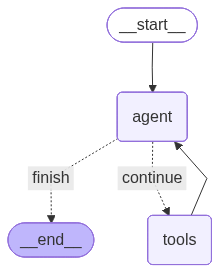

In [29]:
graph = builder.compile()
graph

In [30]:
response = graph.invoke({'messages':[HumanMessage(content="패스트캠퍼스 랭그래프 과정 검색해서 소개해줘.")]})
response

{'messages': [HumanMessage(content='패스트캠퍼스 랭그래프 과정 검색해서 소개해줘.', additional_kwargs={}, response_metadata={}, id='8f715e2b-fc01-40da-82d1-5dcfd039023f'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search', 'arguments': '{"query": "\\ud328\\uc2a4\\ud2b8\\ucea0\\ud37c\\uc2a4 \\ub7ad\\uadf8\\ub798\\ud504 \\uacfc\\uc815"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--01aecc36-1756-4e35-bbf6-69dcfc2434f5-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': '패스트캠퍼스 랭그래프 과정'}, 'id': '9d7c9059-9386-4bec-9a51-7b9ba8d353d4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1782, 'output_tokens': 83, 'total_tokens': 1865, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 57}}),
  ToolMessage(content='{"query": "패스트캠퍼스 랭그래프 과정", "foll

In [31]:
for data in graph.stream(
    {'messages':[HumanMessage(content='''
    오늘 날짜 확인해서 txt 파일로 저장해, 파일 이름은 날짜.txt로 해.''')]}, stream_mode='updates'):
    print(data)
    print('----------')


{'agent': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'current_date', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--65cbdcd1-129c-470f-9707-f859994a722a-0', tool_calls=[{'name': 'current_date', 'args': {}, 'id': 'da413aa0-a9fb-43bb-a37b-4070a7a1a0fb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1790, 'output_tokens': 112, 'total_tokens': 1902, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 102}})}}
----------
{'tools': {'messages': [ToolMessage(content='2025-10-26', name='current_date', id='346d9661-3ae6-4583-bff6-319f830e744c', tool_call_id='da413aa0-a9fb-43bb-a37b-4070a7a1a0fb')]}}
----------
{'agent': {'messages': AIMessage(content=[{'type': 'text', 'text': 'Planning:\n1. Get the current date using